In [ ]:
%matplotlib widget

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
sys.path.append(r"C:/Users/olav2/OneDrive - Norwegian School of Economics/Skrivebord/Master/src")

from bs_module import BSModel


In [ ]:
ticker = yf.Ticker("SPY")

spot = ticker.history(period="1d")["Close"].iloc[-1]
print(f"SPX spot: {spot:.2f}")


In [ ]:
expiries = ticker.options
expiry = expiries[6]      
print("Expiry valgt:", expiry)

In [ ]:
chain = ticker.option_chain(expiry)
calls = chain.calls
puts  = chain.puts

In [ ]:
atm_calls = calls.iloc[(calls["strike"] - spot).abs().argsort()[:1]]
K = float(atm_calls["strike"].iloc[0])
market_price = float(atm_calls["lastPrice"].iloc[0])
T = (pd.to_datetime(expiry) - pd.Timestamp.today()).days / 252

print(f"ATM strike: {K}, markedspris (call): {market_price:.2f}, T={T:.3f}")

In [ ]:
r = 0.0425
q = 0.0    
model = BSModel(r=r, q=q)

model_price = model.price(spot, K, T, sigma=0.103596, option="call")
print(f"Modellpris (sigma=20%): {model_price:.4f}")

In [ ]:
iv = model.implied_vol(
    market_price=market_price,
    S=spot,
    K=K,
    T=T,
    option="call",
    sigma0=0.2,
    tol=1e-6,
    maxiter=50
)
print(f"Implied vol: {iv:.4%}")

In [ ]:
nearest = calls.iloc[(calls["strike"]-spot).abs().argsort()[:5]]

Ks = np.atleast_1d(nearest["strike"].values)
mkt_prices = np.atleast_1d(nearest["lastPrice"].values)
Ts = np.full_like(Ks, T, dtype=float)

Ss = jnp.array([spot]*len(Ks))
Ks_j = jnp.array(Ks)
Ts_j = jnp.array(Ts)
sigmas_guess = jnp.full_like(Ks_j, 0.2)

model_prices = model.price_vec(Ss, Ks_j, Ts_j, sigmas_guess, 'call')
print("Markedspriser:", mkt_prices)
print("Modellpriser:", np.array(model_prices))

ivs = model.implied_vol(mkt_prices, Ss, Ks_j, Ts_j, option='call')
print("Implied vols:", np.array(ivs))


In [ ]:
""" all_results = [] """
"""  """
""" min_days = 10 """
""" max_days = 90 """
"""  """
""" today = pd.Timestamp.utcnow().tz_localize(None) """
"""  """
""" for expiry in ticker.options:   """
"""  """
"""     expiry_date = pd.to_datetime(expiry) """
"""     days_to_expiry = (expiry_date - today).days """
"""  """
"""     if days_to_expiry < min_days or days_to_expiry > max_days: """
"""         continue """
"""  """
"""     chain = ticker.option_chain(expiry) """
"""     calls = chain.calls """
"""  """
"""     strikes = np.atleast_1d(calls["strike"].values) """
"""     mkt_prices = np.atleast_1d(calls["lastPrice"].values) """
"""     T_arr = np.full_like(strikes,  """
"""                          (pd.to_datetime(expiry) - pd.Timestamp.today()).days / 252, """
"""                          dtype=float) """
"""  """
"""     Ss = jnp.array([spot]*len(strikes)) """
"""     Ks_j = jnp.array(strikes) """
"""     Ts_j = jnp.array(T_arr) """
"""  """
"""     ivs = model.implied_vol(mkt_prices, Ss, Ks_j, Ts_j, option='call') """
"""  """
"""     df_iv = pd.DataFrame({ """
"""         "expiry": expiry, """
"""         "spot": spot, """
"""         "strike": strikes, """
"""         "T": T_arr, """
"""         "moneyness": strikes / spot, """
"""         "market_price": mkt_prices, """
"""         "implied_vol": np.array(ivs) """
"""     }) """
"""  """
"""     all_results.append(df_iv) """
"""  """
""" df_surface = pd.concat(all_results, ignore_index=True) """
""" df_surface.to_csv("IV_surface.csv", index=False) """



#Load IV_surface.csv

 df_surface = pd.read_csv("IV_surface.csv")

'  df_surface = pd.read_csv("IV_surface.csv") '

In [66]:

print(df_surface.tail())
print(f"Volatility surface saved to IV_surface.csv with {len(df_surface)} rows")

          expiry        spot  strike         T  moneyness  market_price  \
1185  2025-09-05  637.099976   705.0  0.154762   1.106577          0.06   
1186  2025-09-05  637.099976   710.0  0.154762   1.114425          0.06   
1187  2025-09-05  637.099976   715.0  0.154762   1.122273          0.05   
1188  2025-09-05  637.099976   720.0  0.154762   1.130121          0.03   
1189  2025-09-05  637.099976   730.0  0.154762   1.145817          0.02   

      implied_vol  
1185     0.098183  
1186     0.104583  
1187     0.108630  
1188     0.108727  
1189     0.115618  
Volatility surface saved to IV_surface.csv with 1190 rows


In [67]:
print(df_surface["expiry"].unique())
print(df_surface[["expiry", "T"]].drop_duplicates())

['2025-08-08' '2025-08-15' '2025-08-22' '2025-08-29' '2025-09-19'
 '2025-09-30' '2025-10-17' '2025-08-07' '2025-09-05']
          expiry         T
0     2025-08-08  0.043651
107   2025-08-15  0.071429
400   2025-08-22  0.099206
488   2025-08-29  0.126984
652   2025-09-19  0.210317
821   2025-09-30  0.253968
1024  2025-10-17  0.321429
1089  2025-08-07  0.039683
1131  2025-09-05  0.154762


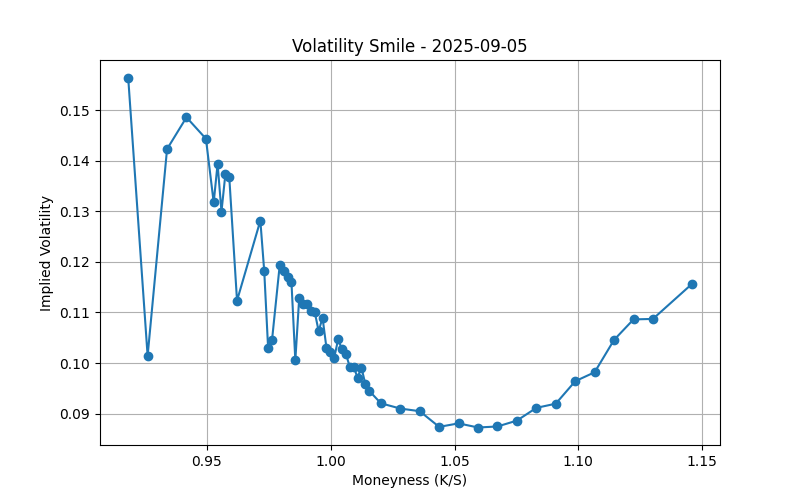

In [69]:
expiry_sel = "2025-09-05"
df_sel = df_surface[df_surface["expiry"] == expiry_sel]

plt.figure(figsize=(8,5))
plt.plot(df_sel["moneyness"], df_sel["implied_vol"], marker='o')
plt.title(f"Volatility Smile - {expiry_sel}")
plt.xlabel("Moneyness (K/S)")
plt.ylabel("Implied Volatility")
plt.grid(True)
plt.show()

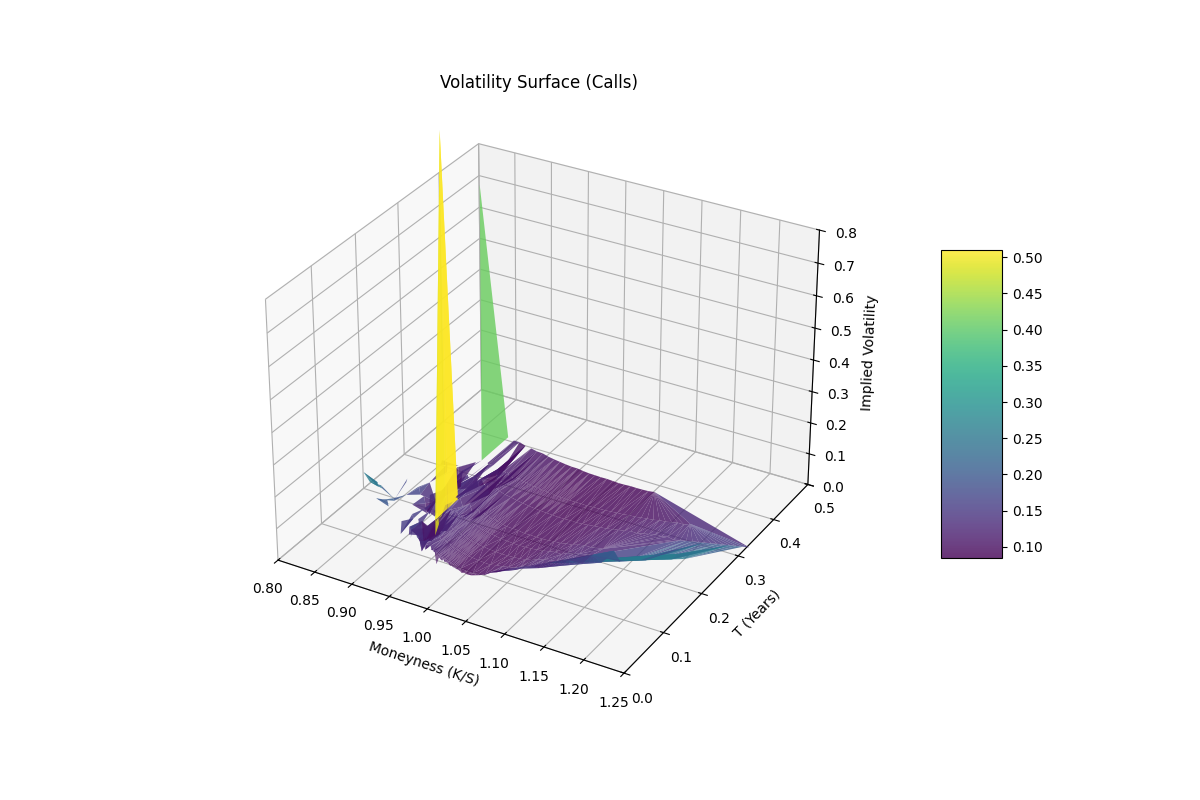

In [73]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Anta at df_surface har kolonnene: moneyness, T, implied_vol
moneyness = df_surface["moneyness"].values
T_vals = df_surface["T"].values
ivs = df_surface["implied_vol"].values

fig = plt.figure(figsize=(12, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')

# 3D trisurf
surf = ax.plot_trisurf(moneyness, T_vals, ivs,
                       cmap='viridis',
                       linewidth=0.1,
                       antialiased=True,
                       alpha=0.8)

ax.set_zlim(0.0, 0.8)  
ax.set_xlim(0.8, 1.25) 
ax.set_ylim(0,0.5)



# Akser og labels
ax.set_xlabel("Moneyness (K/S)")
ax.set_ylabel("T (Years)")
ax.set_zlabel("Implied Volatility")
ax.set_title("Volatility Surface (Calls)")

# Fargebar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, pad=0.1)

plt.show()


Alt under dette er underarbeid i hedging sammenheng

Hedging error: 4.5578


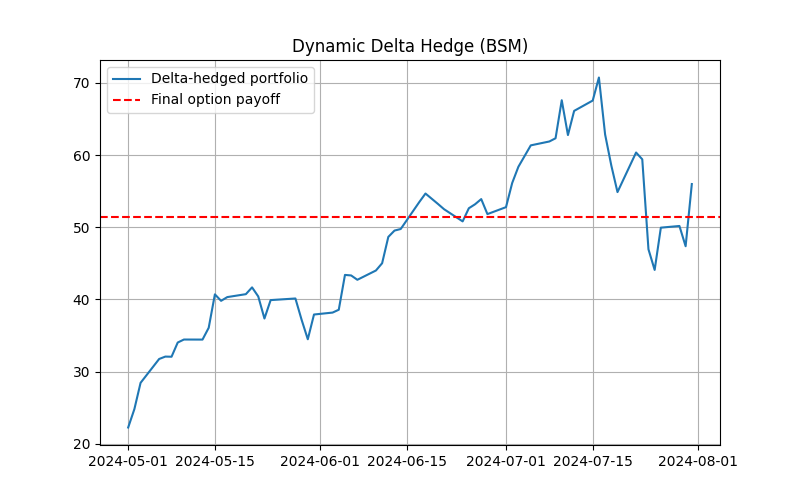

In [104]:
start_date = "2024-05-01"
end_date = "2024-08-01"

r = 0.0425
q = 0.0
sigma = 0.2

data = ticker.history(start=start_date, end=end_date)
spots = data["Close"].values
dates = data.index

K = spots[0]  
T_total = len(spots) / 252

# === Initialiser BSM ===
model = BSModel(r=r, q=q)

# === Startverdier ===
option_value = model.price(spots[0], K, T_total, sigma, option='call')
delta = model.delta(spots[0], K, T_total, sigma, option='call')

cash = option_value - delta * spots[0]  # initial hedge (cash + underliggende)

# === Track PnL ===
portfolio_values = [option_value]

for i in range(1, len(spots)):
    # Tid igjen i år
    T_remaining = (len(spots) - i) / 252

    # Oppdater delta
    new_delta = model.delta(spots[i], K, T_remaining, sigma, option='call')

    # Rebalanser portefølje
    cash = cash * np.exp(r/252) + (delta - new_delta) * spots[i]
    delta = new_delta

    # Verdi av porteføljen (cash + delta * spot)
    portfolio_value = cash + delta * spots[i]
    portfolio_values.append(portfolio_value)

# === Faktisk opsjonsverdi ved slutt ===
final_option_value = max(spots[-1] - K, 0.0)

# === Hedging error ===
hedging_error = portfolio_values[-1] - final_option_value
print(f"Hedging error: {hedging_error:.4f}")

# === Plot PnL over tid ===
plt.figure(figsize=(8,5))
plt.plot(dates, portfolio_values, label="Delta-hedged portfolio")
plt.axhline(final_option_value, color='r', linestyle='--', label="Final option payoff")
plt.title("Dynamic Delta Hedge (BSM)")
plt.legend()
plt.grid(True)
plt.show()

In [98]:
pnl_values = np.array(portfolio_values) - final_option_value
var_95 = np.percentile(pnl_values, 5)
cvar_95 = pnl_values[pnl_values <= var_95].mean()

print("VaR 95%:", var_95)
print("CVaR 95%:", cvar_95)

VaR 95%: -77.16936645507812
CVaR 95%: -79.82835564246544


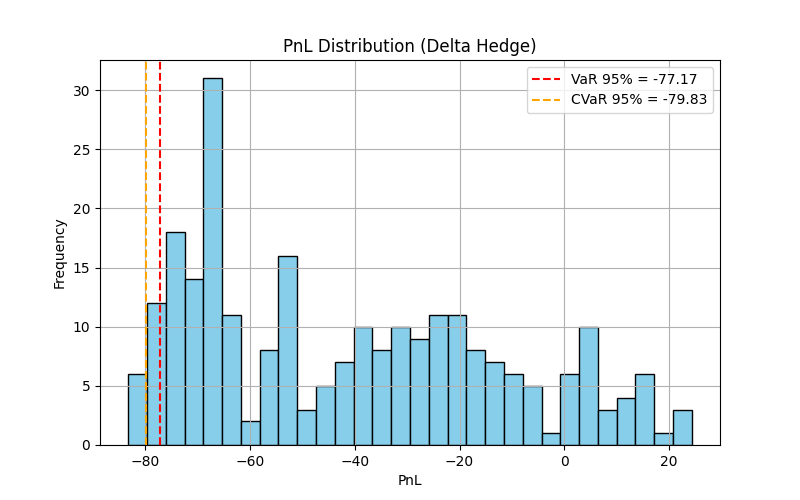

In [99]:
pnl_values = np.array(portfolio_values) - final_option_value

var_95 = np.percentile(pnl_values, 5)
cvar_95 = pnl_values[pnl_values <= var_95].mean()

plt.figure(figsize=(8,5))
plt.hist(pnl_values, bins=30, color='skyblue', edgecolor='k')
plt.axvline(var_95, color='r', linestyle='--', label=f'VaR 95% = {var_95:.2f}')
plt.axvline(cvar_95, color='orange', linestyle='--', label=f'CVaR 95% = {cvar_95:.2f}')
plt.title("PnL Distribution (Delta Hedge)")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()
